In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

AttributeError: module 'keras.utils' has no attribute 'generic_utils'

In [ ]:
# tf.random.set_seed(42)

In [ ]:
data_path = 'data/'

train_csv_file_path = data_path + 'demo_clean_small.csv'
train_image_path = data_path + 'train_v2/'

In [ ]:
def load_csv(path):
    return tf.data.experimental.make_csv_dataset(
        path,
        batch_size=1, # required
        column_names=['ImageId', 'EncodedPixels'],
        num_epochs=1,
        shuffle=False,
    )

train_csv = load_csv(train_csv_file_path)

# for batch in train_csv.take(1):
#     print(batch)

2024-02-10 15:17:34.968451: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-10 15:17:34.968476: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-10 15:17:34.968483: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-10 15:17:34.968516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-10 15:17:34.968532: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
IMG_HEIGHT = 768
IMG_WIDTH = 768

@tf.function
def process_img(file):
    img = tf.io.read_file(train_image_path + file)
    img = tf.io.decode_jpeg(img, channels=3)
    return img

@tf.function
def decode_label_mask(encoded_pixels, image_height, image_width):
    mask = tf.zeros(image_height * image_width, dtype=tf.float32)

    # Convert string to integer tensor
    pairs = tf.strings.to_number(tf.strings.split(encoded_pixels), out_type=tf.int32)

    # Iterate over pairs and update mask
    for i in range(0, len(pairs), 2):
        start = pairs[i] - 1
        run_length = pairs[i + 1]

        indices = tf.range(start, start + run_length)
        updates = tf.ones(run_length, dtype=tf.float32)
        mask = tf.tensor_scatter_nd_update(mask, indices=tf.expand_dims(indices, axis=1), updates=updates)

    return  tf.transpose(tf.reshape(mask, (image_height, image_width)))

@tf.function
def process_label(label):
    return decode_label_mask(label, IMG_HEIGHT, IMG_WIDTH)

@tf.function
def process_batch(csv_item):
    X = process_img(csv_item['ImageId'])
    y = process_label(csv_item['EncodedPixels'])
    return X, y

def plot_ds_element(background, overlay):
    fig, ax = plt.subplots()
    plt.imshow(background)
    ax.imshow(overlay, alpha=0.3)

train_ds = train_csv.unbatch().map(process_batch)

# for item, label in train_ds.skip(5).take(1):
#     plot_ds_element(item, label)


In [ ]:
model = sm.Unet('efficientnetb3', classes=1, activation='sigmoid')

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile('adam', sm.losses.DiceLoss(), metrics)

In [8]:
from datetime import datetime
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

train_ds = train_ds.batch(1).prefetch(buffer_size=tf.data.AUTOTUNE)

model.fit(train_ds, epochs=100, callbacks=[tensorboard_callback])

Epoch 1/100


2024-02-10 15:17:46.840726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


      9/Unknown - 22s 778ms/step - loss: 0.9887 - iou_score: 0.0062 - f1-score: 0.0121

2024-02-10 15:18:03.799738: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10321012830879711656
2024-02-10 15:18:03.799755: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16379758290519597796
2024-02-10 15:18:03.799760: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1322748366501324212
2024-02-10 15:18:03.799766: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17836289932062759576
2024-02-10 15:18:03.799771: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7341612611530836824
2024-02-10 15:18:03.799782: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1152757264247003864
2024-02-10 15:18:03.799788: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

9/9 [==============================] - 22s 813ms/step - loss: 0.9887 - iou_score: 0.0062 - f1-score: 0.0121
Epoch 2/100
9/9 [==============================] - 6s 635ms/step - loss: 0.9751 - iou_score: 0.0295 - f1-score: 0.0532
Epoch 3/100
9/9 [==============================] - 6s 613ms/step - loss: 0.9686 - iou_score: 0.0709 - f1-score: 0.1116
Epoch 4/100
9/9 [==============================] - 6s 614ms/step - loss: 0.9604 - iou_score: 0.1043 - f1-score: 0.1527
Epoch 5/100
9/9 [==============================] - 5s 610ms/step - loss: 0.9498 - iou_score: 0.1448 - f1-score: 0.1998
Epoch 6/100
9/9 [==============================] - 6s 612ms/step - loss: 0.9314 - iou_score: 0.1589 - f1-score: 0.2127
Epoch 7/100
9/9 [==============================] - 6s 612ms/step - loss: 0.9105 - iou_score: 0.1890 - f1-score: 0.2502
Epoch 8/100
9/9 [==============================] - 6s 610ms/step - loss: 0.8824 - iou_score: 0.1878 - f1-score: 0.2404
Epoch 9/100
9/9 [==============================] - 6s 611ms

1/1 [==============================] - 0s 437ms/step


2024-02-10 15:29:22.489107: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2719330720436465834
2024-02-10 15:29:22.489126: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13581170031359304022
2024-02-10 15:29:22.489133: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1178398133729698559
2024-02-10 15:29:22.489136: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1372375466093245593
2024-02-10 15:29:22.489140: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9411165903377417817
2024-02-10 15:29:22.489144: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3317564622132365463
2024-02-10 15:29:22.489149: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

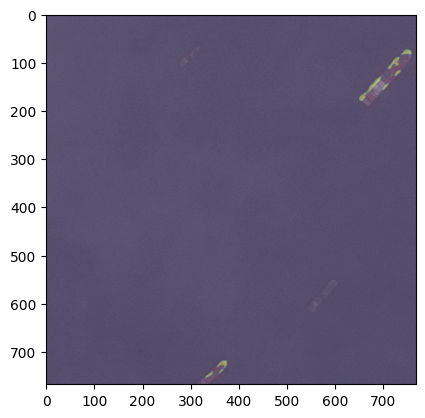

In [12]:
item = train_ds.skip(7).take(1)
p = model.predict(item)

for item, label in train_ds.unbatch().skip(7).take(1):
    plot_ds_element(item, p[0])